In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.ndimage.interpolation import shift
%matplotlib inline

### Load Data

In [185]:
df = pd.read_csv('test_restaurant.csv')
df.head()

,date,num_visitors
0,2000-01-01,49.128490
1,2000-01-02,50.288060
2,2000-01-03,53.549213
3,2000-01-04,45.453240
4,2000-01-05,49.469402


There's an obvious trend and seasonality.

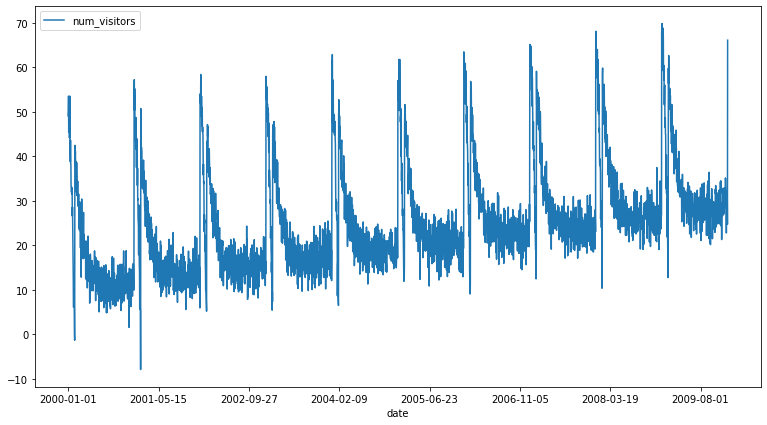

In [186]:
df.plot(x='date', figsize=(13,7))

Let's zoom in to find the period of the seasonality.

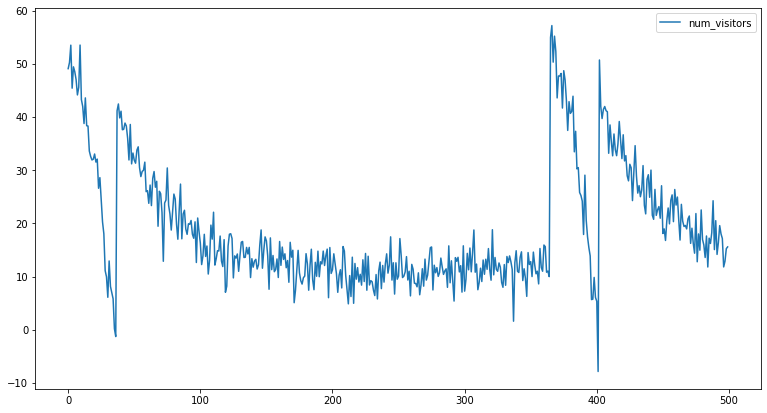

In [187]:
df.iloc[:500].plot(figsize=(13,7))

Period of seasonality is approximately 365

### Preprocessing

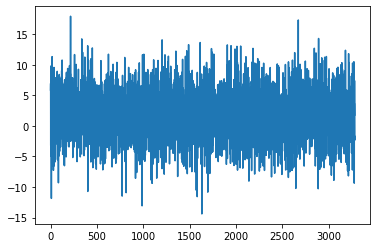

In [188]:
# remove trend and seasonality
data = df.num_visitors
data = data.diff(365).iloc[365:]
float_data=np.array(data).astype(float)
plt.plot(float_data)

In [189]:
# normalize
train_size = int(len(float_data)*0.8)  # 80% training data
mean = float_data[:train_size].mean()
float_data -= mean
std = float_data[:train_size].std()
float_data /= std

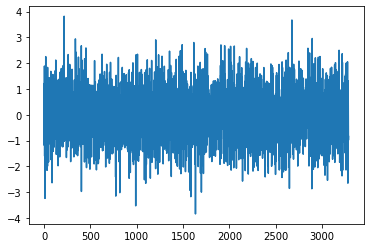

In [190]:
plt.plot(float_data)

### Establish baseline using Naive Forecasting

Naive forecast is to assume that the forecast today is the same as yesterday.

In [191]:
from sklearn.metrics import r2_score
true = df.num_visitors[1:]
lagged = shift(df.num_visitors, 1)[1:]

print('Naive method R2: ', r2_score(true[train_size:], lagged[train_size:]))

Naive method R2:  0.6744390854123723


This is our score to beat, our model must outperform the R-squared score of the naive forecast.

### Split sequences
Reference: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [192]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def save(var, filename):
    pickle.dump(var, open(filename, 'wb'))

In [203]:
# normalize
data = df.num_visitors
float_data=np.array(data).astype(float)
train_size = int(len(float_data)*0.8)  # 80% training data
mean = float_data[:train_size].mean()
float_data -= mean
std = float_data[:train_size].std()
float_data /= std

# save mean and std
mean_std = tuple((mean, std))
save(mean_std, 'mean_std.pkl')

lookback=7 # use 7 days data to predict next day

# Train sets
X, y = split_sequence(float_data[:train_size], lookback)

# Test sets
xtest, ytest = split_sequence(float_data[train_size:], lookback)

save(xtest, 'xtest.pkl')

### Forecast Model

Use RF and GBM

In [194]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [195]:
reg_rf = RandomForestRegressor(random_state=42)
reg_gb = GradientBoostingRegressor(random_state=42)

In [196]:
reg_rf.fit(X, y);
reg_gb.fit(X, y);

print('RF R-square: ', reg_rf.score(xtest, ytest))
print('GB R-square: ', reg_gb.score(xtest, ytest))

RF R-square:  0.7404131143413903
GB R-square:  0.7414116295277418


Great! Both models outperformed the baseline.

### Make prediction for next day

In [197]:
pred = reg_rf.predict(np.array(xtest[-1]).reshape(1, -1))
pred *= std
pred += mean

print('RF prediction for next day: ', pred[0])

RF prediction for next day:  26.90273319


In [198]:
pred = reg_gb.predict(np.array(xtest[-1]).reshape(1, -1))
pred *= std
pred += mean

print('GB prediction for next day: ', pred[0])

GB prediction for next day:  26.971254664620627


### Save models

In [199]:
save(reg_rf, 'rf.pkl')
save(reg_gb, 'gb.pkl')

In [7]:
from whatsbusy import *

In [8]:
predict_next_day()

Prediction for next day:  26.90273319
